# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from collections import defaultdict

ECG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_ECG-only.csv").drop(columns = "ID")
EDA_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EDA-only.csv").drop(columns = "ID")
EEG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EEG-only.csv").drop(columns = "ID")
EYE_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EYE-only.csv").drop(columns = "ID").replace([np.inf, -np.inf], np.nan).interpolate()
fNIRS_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_fNIRS-only.csv").drop(columns = "ID")
RSP_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_RSP-only.csv").drop(columns = "ID")

# Pre-Processing

In [2]:
# Isolate the outcomes variables
outcomes_df = ECG_df.iloc[:, ECG_df.shape[1] - 4:]

# Create binary variables for high and low 
adj_SA_1_median = np.median(outcomes_df["adjSA1"])
adj_SA_2_median = np.median(outcomes_df["adjSA2"])
adj_SA_3_median = np.median(outcomes_df["adjSA3"])
adj_SA_tot_median = np.median(outcomes_df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
outcomes_df["Lv_1_Hi"] = (outcomes_df["adjSA1"] >= adj_SA_1_median).astype(int)
outcomes_df["Lv_2_Hi"] = (outcomes_df["adjSA2"] >= adj_SA_2_median).astype(int)
outcomes_df["Lv_3_Hi"] = (outcomes_df["adjSA3"] >= adj_SA_3_median).astype(int)
outcomes_df["Tot_Hi"] = (outcomes_df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

# Remove outcomes variables from each sensor dataframe
ECG_df = ECG_df.iloc[:, :ECG_df.shape[1] - 4]
EDA_df = EDA_df.iloc[:, :EDA_df.shape[1] - 4]
EEG_df = EEG_df.iloc[:, :EEG_df.shape[1] - 4]
EYE_df = EYE_df.iloc[:, :EYE_df.shape[1] - 4]
fNIRS_df = fNIRS_df.iloc[:, :fNIRS_df.shape[1] - 4]
RSP_df = RSP_df.iloc[:, :RSP_df.shape[1] - 4]

# Free Memory
del adj_SA_1_median
del adj_SA_2_median
del adj_SA_3_median
del adj_SA_tot_median

# Training Models

In [3]:
def evaluate_models(sensor_df, outcomes_df, outcome_var):
    test_scores = defaultdict(list)
    CV_models = defaultdict(list)

    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(sensor_df, outcomes_df[outcome_var])):
        # Train-Test Split for the Fold
        pred_CV = sensor_df.iloc[CV_idx, :]
        pred_test = sensor_df.iloc[test_idx, :]
        out_CV = outcomes_df.iloc[CV_idx, :]
        out_test = outcomes_df.iloc[test_idx, :]

        cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 42)

        # Initialize Models
        reg_model = LogisticRegression(
            penalty = None,
            fit_intercept = False, 
            n_jobs = -1, 
            max_iter = 20000,
            solver = "saga")

        Ridge_model = LogisticRegressionCV(
            Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
            cv = cv, 
            fit_intercept = False, 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = "accuracy", 
            refit = True)

        LASSO_model = LogisticRegressionCV(
            Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
            cv = cv, 
            fit_intercept = False, 
            penalty = "l1", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = "accuracy", 
            refit = True)
        
        # elastic_model = LogisticRegressionCV(
        #     Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
        #     l1_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        #     cv = cv, 
        #     fit_intercept = False, 
        #     penalty = "elasticnet", 
        #     solver = "saga", 
        #     n_jobs = -1, 
        #     max_iter = 10000, 
        #     scoring = "accuracy", 
        #     refit = True)



        # Fit Models with CV Splits
        reg_model.fit(pred_CV, out_CV[outcome_var])
        Ridge_model.fit(pred_CV, out_CV[outcome_var])
        LASSO_model.fit(pred_CV, out_CV[outcome_var])
        # elastic_model.fit(pred_CV, out_CV[outcome_var])



        # Append Best Model's Score
        test_scores["Regular"].append(reg_model.score(pred_test, out_test[outcome_var]))
        test_scores["Ridge"].append(Ridge_model.score(pred_test, out_test[outcome_var]))
        test_scores["LASSO"].append(LASSO_model.score(pred_test, out_test[outcome_var]))
        # test_scores["Elasticnet"].append(elastic_model.score(pred_test, out_test[outcome_var]))



        # Append CV models
        CV_models["Regular"].append(reg_model)
        CV_models["Ridge"].append(Ridge_model)
        CV_models["LASSO"].append(LASSO_model)
        # CV_models["Elasticnet"].append(elastic_model)

    return test_scores, CV_models

In [7]:
all_sensor_test_scores = [{
    "Lv_1_Hi": [],
    "Lv_2_Hi": [],
    "Lv_3_Hi": [],
    "Tot_Hi": []
} for i in range(6)]

all_sensor_CV_models = [{
    "Lv_1_Hi": [],
    "Lv_2_Hi": [],
    "Lv_3_Hi": [],
    "Tot_Hi": []
} for i in range(6)]

sensor_map = {
    0: "ECG",
    1: "EDA",
    2: "EEG",
    3: "EYE",
    4: "fNIRS",
    5: "RSP"
}

# Indices:
# 0 -> ECG
# 1 -> EDA
# 2 -> EEG
# 3 -> EYE
# 4 -> fNIRS
# 5 -> RSP

In [11]:
# Save into file
with open("model_by_sensor.pkl", "wb") as f:
    pickle.dump((all_sensor_test_scores, all_sensor_CV_models), f)

In [8]:
# Load Test Scores and CV Models from File
with open("model_by_sensor.pkl", "rb") as f:
    all_sensor_test_scores, all_sensor_CV_models = pickle.load(f)

## SA 1

In [ ]:
# 44 Mins
lvl = "Lv_1_Hi"

all_sensor_test_scores[0][lvl], all_sensor_CV_models[0][lvl] = evaluate_models(ECG_df, outcomes_df, lvl)
print("ECG Models Done")
all_sensor_test_scores[1][lvl], all_sensor_CV_models[1][lvl] = evaluate_models(EDA_df, outcomes_df, lvl)
print("EDA Models Done")
all_sensor_test_scores[2][lvl], all_sensor_CV_models[2][lvl] = evaluate_models(EEG_df, outcomes_df, lvl)
print("EEG Models Done")
all_sensor_test_scores[3][lvl], all_sensor_CV_models[3][lvl] = evaluate_models(EYE_df, outcomes_df, lvl)
print("EYE Models Done")
all_sensor_test_scores[4][lvl], all_sensor_CV_models[4][lvl] = evaluate_models(fNIRS_df, outcomes_df, lvl)
print("fNIRS Models Done")
all_sensor_test_scores[5][lvl], all_sensor_CV_models[5][lvl] = evaluate_models(RSP_df, outcomes_df, lvl)
print("RSP Models Done")

ECG Models Done
EDA Models Done
EEG Models Done
EYE Models Done
fNIRS Models Done


/home/jshen/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jshen/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RSP Models Done


## SA 2

In [9]:
lvl = "Lv_2_Hi"

all_sensor_test_scores[0][lvl], all_sensor_CV_models[0][lvl] = evaluate_models(ECG_df, outcomes_df, lvl)
print("ECG Models Done")
all_sensor_test_scores[1][lvl], all_sensor_CV_models[1][lvl] = evaluate_models(EDA_df, outcomes_df, lvl)
print("EDA Models Done")
all_sensor_test_scores[2][lvl], all_sensor_CV_models[2][lvl] = evaluate_models(EEG_df, outcomes_df, lvl)
print("EEG Models Done")
all_sensor_test_scores[3][lvl], all_sensor_CV_models[3][lvl] = evaluate_models(EYE_df, outcomes_df, lvl)
print("EYE Models Done")
all_sensor_test_scores[4][lvl], all_sensor_CV_models[4][lvl] = evaluate_models(fNIRS_df, outcomes_df, lvl)
print("fNIRS Models Done")
all_sensor_test_scores[5][lvl], all_sensor_CV_models[5][lvl] = evaluate_models(RSP_df, outcomes_df, lvl)
print("RSP Models Done")

ECG Models Done
EDA Models Done
EEG Models Done
EYE Models Done
fNIRS Models Done
RSP Models Done


## SA 3

In [9]:
lvl = "Lv_3_Hi"

all_sensor_test_scores[0][lvl], all_sensor_CV_models[0][lvl] = evaluate_models(ECG_df, outcomes_df, lvl)
print("ECG Models Done")
all_sensor_test_scores[1][lvl], all_sensor_CV_models[1][lvl] = evaluate_models(EDA_df, outcomes_df, lvl)
print("EDA Models Done")
all_sensor_test_scores[2][lvl], all_sensor_CV_models[2][lvl] = evaluate_models(EEG_df, outcomes_df, lvl)
print("EEG Models Done")
all_sensor_test_scores[3][lvl], all_sensor_CV_models[3][lvl] = evaluate_models(EYE_df, outcomes_df, lvl)
print("EYE Models Done")
all_sensor_test_scores[4][lvl], all_sensor_CV_models[4][lvl] = evaluate_models(fNIRS_df, outcomes_df, lvl)
print("fNIRS Models Done")
all_sensor_test_scores[5][lvl], all_sensor_CV_models[5][lvl] = evaluate_models(RSP_df, outcomes_df, lvl)
print("RSP Models Done")

ECG Models Done
EDA Models Done
EEG Models Done
EYE Models Done
fNIRS Models Done
RSP Models Done


## Total SA

In [10]:
lvl = "Tot_Hi"

all_sensor_test_scores[0][lvl], all_sensor_CV_models[0][lvl] = evaluate_models(ECG_df, outcomes_df, lvl)
print("ECG Models Done")
all_sensor_test_scores[1][lvl], all_sensor_CV_models[1][lvl] = evaluate_models(EDA_df, outcomes_df, lvl)
print("EDA Models Done")
all_sensor_test_scores[2][lvl], all_sensor_CV_models[2][lvl] = evaluate_models(EEG_df, outcomes_df, lvl)
print("EEG Models Done")
all_sensor_test_scores[3][lvl], all_sensor_CV_models[3][lvl] = evaluate_models(EYE_df, outcomes_df, lvl)
print("EYE Models Done")
all_sensor_test_scores[4][lvl], all_sensor_CV_models[4][lvl] = evaluate_models(fNIRS_df, outcomes_df, lvl)
print("fNIRS Models Done")
all_sensor_test_scores[5][lvl], all_sensor_CV_models[5][lvl] = evaluate_models(RSP_df, outcomes_df, lvl)
print("RSP Models Done")

ECG Models Done
EDA Models Done
EEG Models Done
EYE Models Done
fNIRS Models Done
RSP Models Done


# Graphing Test Scores

In [12]:
def graph_folds(all_sensor_test_scores, outcome_var):
    for i in range(6):
        width = 0.3
        idx = 0
        x_vals = np.arange(1, 6)
        plt.figure(figsize = (10, 5))
        sensor_test_scores = all_sensor_test_scores[i][outcome_var]

        # No Penalty Bars
        plt.bar(x_vals - width, sensor_test_scores["Regular"], width, label = "No Penalty")
        for j in x_vals - 1:
            plt.text(j - width + 1, sensor_test_scores["Regular"][j], round(sensor_test_scores["Regular"][j], 3), ha = "center")
            
        # Ridge Bars
        plt.bar(x_vals, sensor_test_scores["Ridge"], width, label = "Ridge")
        for j in x_vals - 1:
            plt.text(j + 1, sensor_test_scores["Ridge"][j], round(sensor_test_scores["Ridge"][j], 3), ha = "center")

        # LASSO Bars
        plt.bar(x_vals + width, sensor_test_scores["LASSO"], width, label = "LASSO")
        for j in x_vals - 1:
            plt.text(j + width + 1, sensor_test_scores["LASSO"][j], round(sensor_test_scores["LASSO"][j], 3), ha = "center")

        # 0.5 Line
        plt.axhline(y = 0.5, color = "r")

        plt.ylim([0.3, 0.7])

        plt.xlabel("Test Fold")
        plt.ylabel("Accuracy Score")
        plt.title(sensor_map[i] + " Test Fold Accuracy Scores for " + outcome_var)

        plt.legend(loc = "lower right")

## SA 1

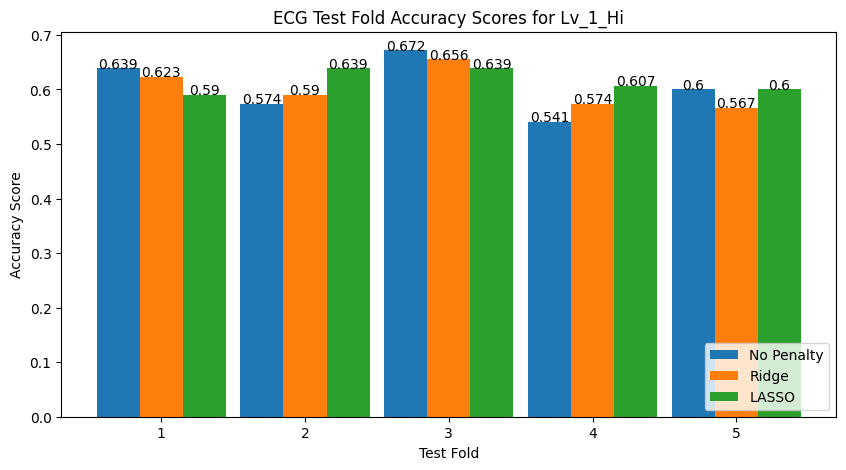

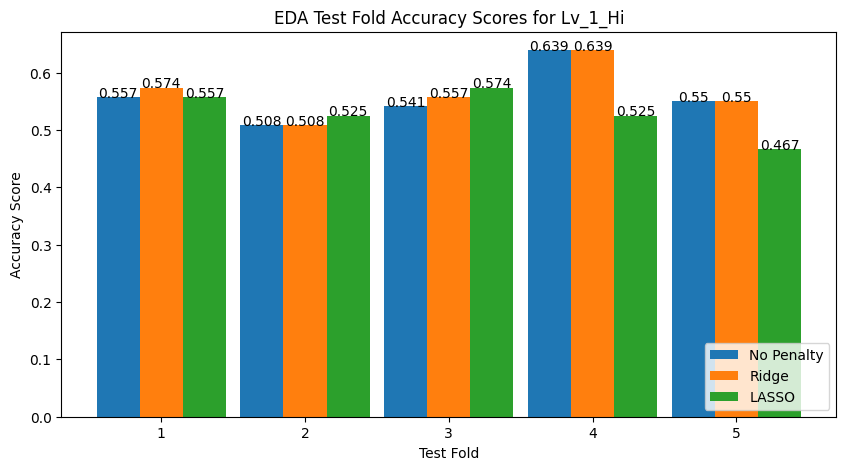

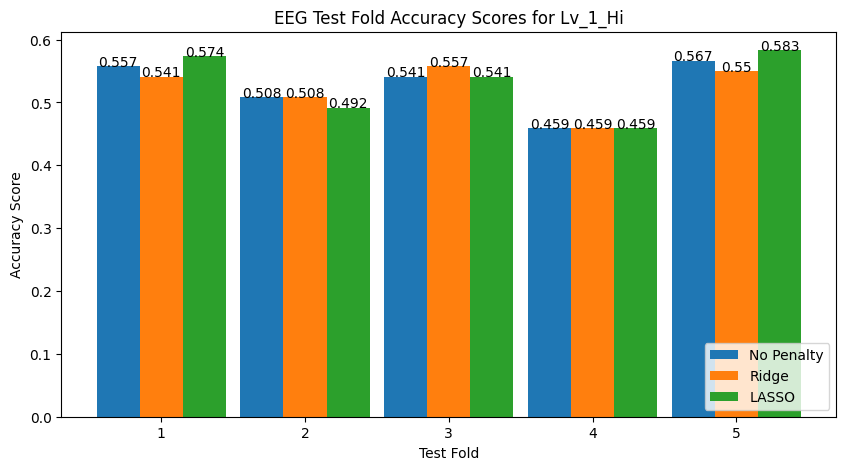

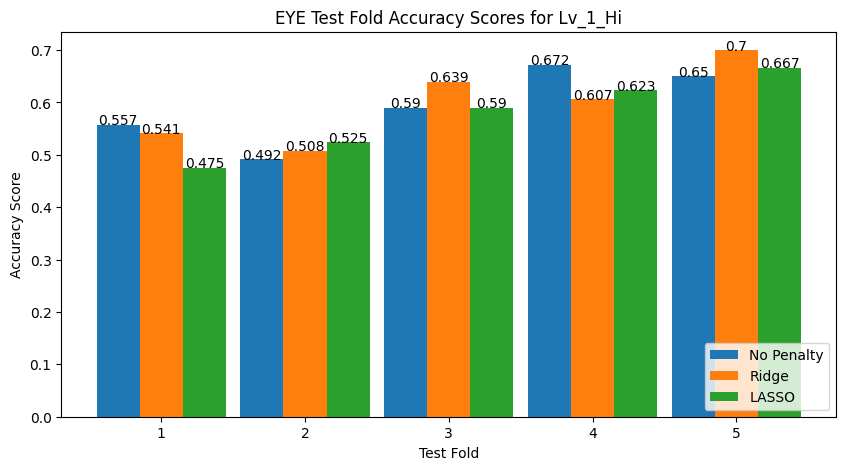

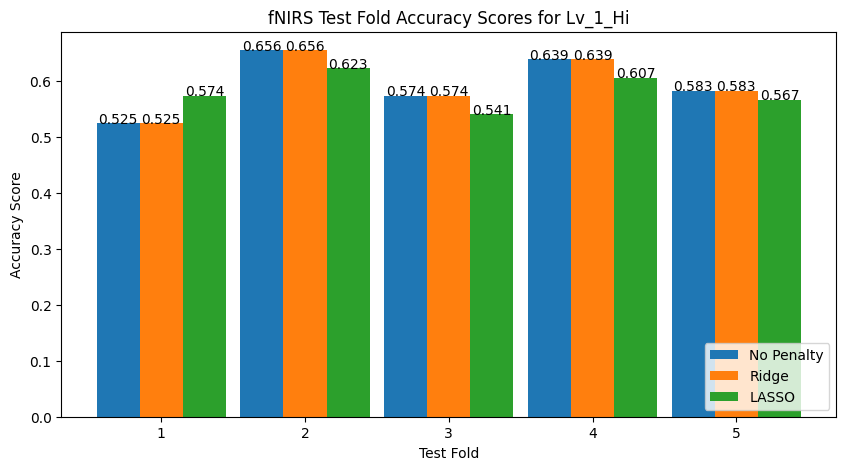

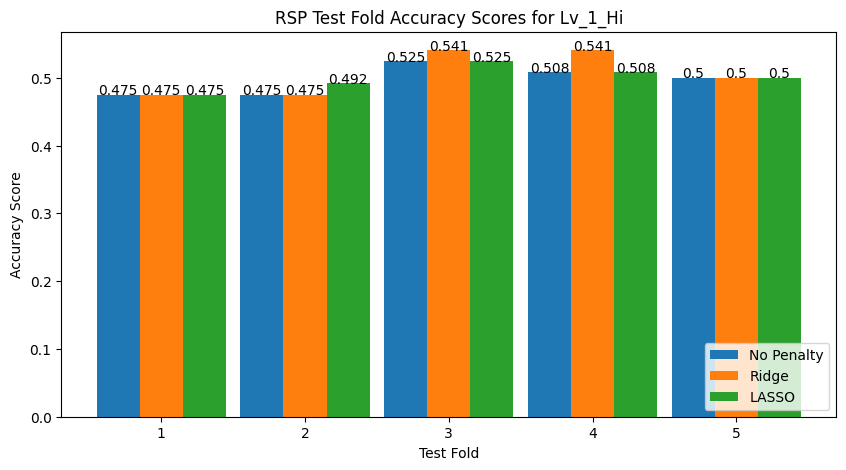

In [45]:
graph_folds(all_sensor_test_scores, "Lv_1_Hi")

In [47]:
all_sensor_test_scores[5]["Lv_1_Hi"]

defaultdict(list,
            {'Regular': [0.47540983606557374,
              0.47540983606557374,
              0.5245901639344263,
              0.5081967213114754,
              0.5],
             'Ridge': [0.47540983606557374,
              0.47540983606557374,
              0.5409836065573771,
              0.5409836065573771,
              0.5],
             'LASSO': [0.47540983606557374,
              0.4918032786885246,
              0.5245901639344263,
              0.5081967213114754,
              0.5]})

In [60]:
for model in all_sensor_CV_models[0]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(ECG_df.columns)[np.array(model.coef_ != 0)[0]])


7
['ECG_SDNN_version02' 'ECG_SDNN_version04' 'ECG_SDNN_version10'
 'ECG_SDNN_version20' 'ECG_Heartrate_version02' 'ECG_RMSSD_version02'
 'ECG_RMSSD_version10']
7
['ECG_SDNN_version02' 'ECG_SDNN_version10' 'ECG_Heartrate_version02'
 'ECG_RMSSD_version02' 'ECG_RMSSD_version03' 'ECG_RMSSD_version09'
 'ECG_RMSSD_version10']
10
['ECG_SDNN_version02' 'ECG_SDNN_version04' 'ECG_SDNN_version10'
 'ECG_SDNN_version20' 'ECG_Heartrate_version02' 'ECG_RMSSD_version02'
 'ECG_RMSSD_version03' 'ECG_RMSSD_version04' 'ECG_RMSSD_version09'
 'ECG_RMSSD_version10']
17
['ECG_SDNN_version02' 'ECG_SDNN_version03' 'ECG_SDNN_version04'
 'ECG_SDNN_version05' 'ECG_SDNN_version09' 'ECG_SDNN_version10'
 'ECG_SDNN_version19' 'ECG_SDNN_version20' 'ECG_Heartrate_version02'
 'ECG_Heartrate_version04' 'ECG_Heartrate_version09'
 'ECG_Heartrate_version20' 'ECG_RMSSD_version02' 'ECG_RMSSD_version03'
 'ECG_RMSSD_version05' 'ECG_RMSSD_version10' 'ECG_RMSSD_version19']
7
['ECG_SDNN_version02' 'ECG_SDNN_version04' 'ECG_SDNN_ver

In [62]:
for model in all_sensor_CV_models[1]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(EDA_df.columns)[np.array(model.coef_ != 0)[0]])

72
['EDA_TonicMean_version04' 'EDA_TonicMean_version05'
 'EDA_TonicMean_version09' 'EDA_TonicMean_version10'
 'EDA_TonicMean_version11' 'EDA_TonicMean_version12'
 'EDA_TonicMean_version16' 'EDA_TonicMean_version17'
 'EDA_TonicMean_version19' 'EDA_TonicMean_version22'
 'EDA_TonicMean_version23' 'EDA_TonicMin_version02'
 'EDA_TonicMin_version03' 'EDA_TonicMin_version04'
 'EDA_TonicMin_version05' 'EDA_TonicMin_version09'
 'EDA_TonicMin_version10' 'EDA_TonicMin_version11'
 'EDA_TonicMin_version12' 'EDA_TonicMin_version16'
 'EDA_TonicMin_version17' 'EDA_TonicMin_version22'
 'EDA_TonicMin_version23' 'EDA_TonicMax_version02'
 'EDA_TonicMax_version04' 'EDA_TonicMax_version05'
 'EDA_TonicMax_version10' 'EDA_TonicMax_version11'
 'EDA_TonicMax_version12' 'EDA_TonicMax_version16'
 'EDA_TonicMax_version17' 'EDA_TonicMax_version19'
 'EDA_TonicMax_version22' 'EDA_TonicMax_version23'
 'EDA_PhasicMean_version09' 'EDA_PhasicMean_version11'
 'EDA_PhasicMean_version12' 'EDA_PhasicMean_version16'
 'EDA_Pha

In [65]:
for model in all_sensor_CV_models[2]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

319
76
328
245
91


In [67]:
for model in all_sensor_CV_models[3]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(EYE_df.columns)[np.array(model.coef_ != 0)[0]])

29
['EYE_BlinkDuration_version16' 'EYE_FixationDuration_version02'
 'EYE_FixationDuration_version03' 'EYE_FixationDuration_version04'
 'EYE_FixationDuration_version05' 'EYE_FixationDuration_version09'
 'EYE_FixationDuration_version10' 'EYE_FixationDuration_version19'
 'EYE_FixationDuration_version20' 'EYE_corm_version03'
 'EYE_corm_version09' 'EYE_corm_version19' 'EYE_lam_version02'
 'EYE_lam_version03' 'EYE_lam_version04' 'EYE_lam_version05'
 'EYE_lam_version09' 'EYE_lam_version19' 'EYE_lam_version20'
 'EYE_det_version02' 'EYE_det_version03' 'EYE_det_version04'
 'EYE_det_version05' 'EYE_det_version09' 'EYE_det_version10'
 'EYE_det_version20' 'EYE_rec_version03' 'EYE_rec_version05'
 'EYE_rec_version09']
6
['EYE_FixationDuration_version03' 'EYE_FixationDuration_version04'
 'EYE_FixationDuration_version10' 'EYE_det_version02' 'EYE_det_version03'
 'EYE_det_version04']
6
['EYE_FixationDuration_version03' 'EYE_FixationDuration_version04'
 'EYE_FixationDuration_version10' 'EYE_lam_version04'

In [68]:
for model in all_sensor_CV_models[4]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

751
265
239
245
1756


In [70]:
for model in all_sensor_CV_models[5]["Lv_1_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(RSP_df.columns)[np.array(model.coef_ != 0)[0]])

22
['RSP_MedianAmplitude_version02' 'RSP_MedianAmplitude_version04'
 'RSP_RR_version03' 'RSP_RR_version05' 'RSP_RR_version19'
 'RSP_RR_version20' 'RSP_RR_version22' 'RSP_RR_version23'
 'RSP_TV_version02' 'RSP_TV_version03' 'RSP_TV_version04'
 'RSP_TV_version05' 'RSP_TV_version11' 'RSP_TV_version12'
 'RSP_TV_version20' 'RSP_MV_version02' 'RSP_MV_version03'
 'RSP_MV_version04' 'RSP_MV_version05' 'RSP_MV_version19'
 'RSP_MV_version20' 'RSP_MV_version22']
2
['RSP_TV_version11' 'RSP_TV_version12']
11
['RSP_TV_version03' 'RSP_TV_version04' 'RSP_TV_version05'
 'RSP_TV_version11' 'RSP_TV_version12' 'RSP_TV_version19'
 'RSP_TV_version20' 'RSP_MV_version02' 'RSP_MV_version03'
 'RSP_MV_version05' 'RSP_MV_version20']
2
['RSP_TV_version11' 'RSP_TV_version12']
2
['RSP_TV_version11' 'RSP_TV_version12']


In [85]:
for i in range(6):
    for model_type in all_sensor_test_scores[i]["Lv_1_Hi"]:
        print(model_type, np.mean(all_sensor_test_scores[i]["Lv_1_Hi"][model_type]))
    print()

Regular 0.6052459016393443
Ridge 0.6018579234972676
LASSO 0.6150819672131148

Regular 0.5591803278688525
Ridge 0.5657377049180328
LASSO 0.5293989071038252

Regular 0.5264480874316939
Ridge 0.5231147540983606
LASSO 0.5297814207650273

Regular 0.592295081967213
Ridge 0.5990163934426229
LASSO 0.5759562841530055

Regular 0.5953551912568307
Ridge 0.5953551912568307
LASSO 0.5821857923497268

Regular 0.49672131147540977
Ridge 0.5065573770491804
LASSO 0.5



In [14]:
SA_1_sensor_predictions = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

In [15]:
# Gather predictions for each fold
model_type = "LASSO"
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df["Lv_1_Hi"])):
    # Append predictions for test fold
    SA_1_sensor_predictions["ECG"].append(all_sensor_CV_models[0]["Lv_1_Hi"][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["EDA"].append(all_sensor_CV_models[1]["Lv_1_Hi"][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["EEG"].append(all_sensor_CV_models[2]["Lv_1_Hi"][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["EYE"].append(all_sensor_CV_models[3]["Lv_1_Hi"][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["fNIRS"].append(all_sensor_CV_models[4]["Lv_1_Hi"][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["RSP"].append(all_sensor_CV_models[5]["Lv_1_Hi"][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_1_sensor_predictions["test_fold"].append(outcomes_df["Lv_1_Hi"].iloc[test_idx].to_list())

In [17]:
combined_test_scores = []
for a in range(5):
    combined_test_scores.append(accuracy_score(
        SA_1_sensor_predictions["test_fold"][a], 
        (SA_1_sensor_predictions["ECG"][a] + 
         SA_1_sensor_predictions["EDA"][a] +
         SA_1_sensor_predictions["EEG"][a] + 
         SA_1_sensor_predictions["EYE"][a] + 
         SA_1_sensor_predictions["fNIRS"][a]) >= 3))
    
print(combined_test_scores)

[0.6229508196721312, 0.639344262295082, 0.6229508196721312, 0.639344262295082, 0.6333333333333333]


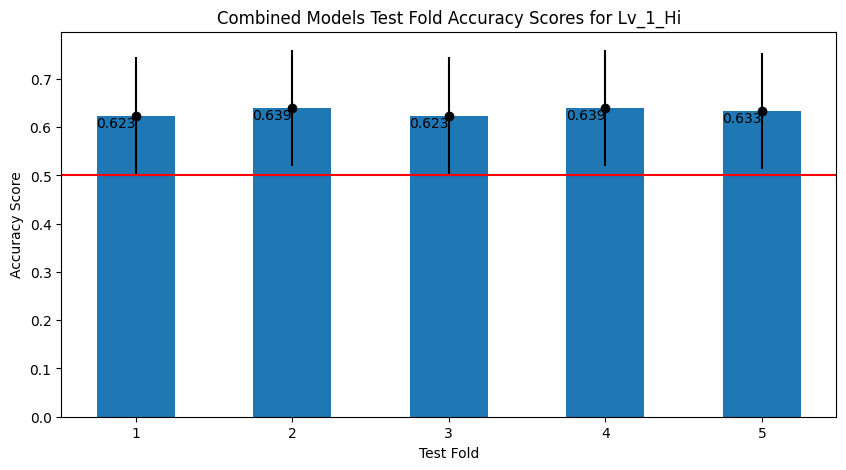

In [25]:
width = 0.5
x_vals = np.arange(1, 6)
plt.figure(figsize = (10, 5))

errors = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores]

# LASSO Bars
plt.bar(x_vals, combined_test_scores, width)
for j in x_vals - 1:
    plt.text(j + 1, combined_test_scores[j], round(combined_test_scores[j], 3), ha = "right", va = "top")

# Add Error Bars
plt.errorbar(x_vals, combined_test_scores, yerr = errors, fmt = "o", c = "black")
plt.axhline(y = 0.5, color = "r")

plt.xlabel("Test Fold")
plt.ylabel("Accuracy Score")
plt.title("Combined Models Test Fold Accuracy Scores for Lv_1_Hi")
plt.show()

## SA 2

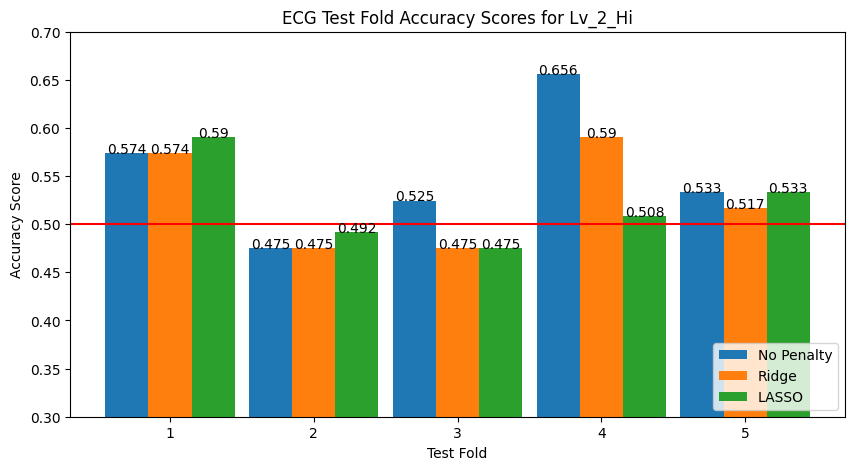

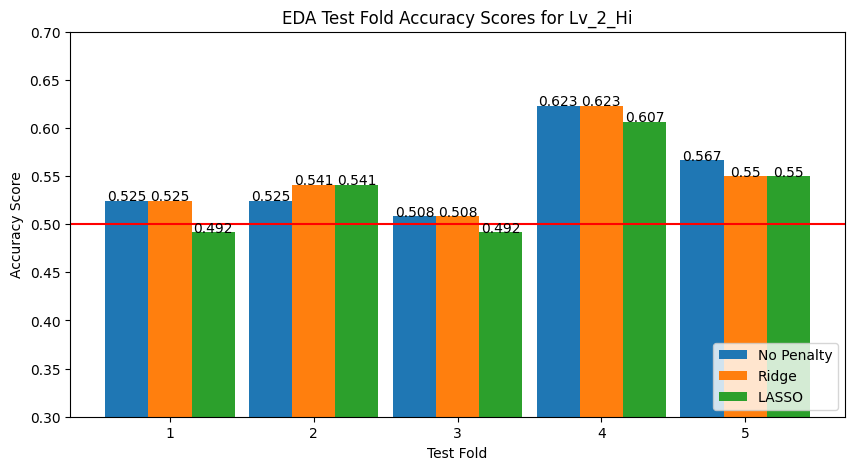

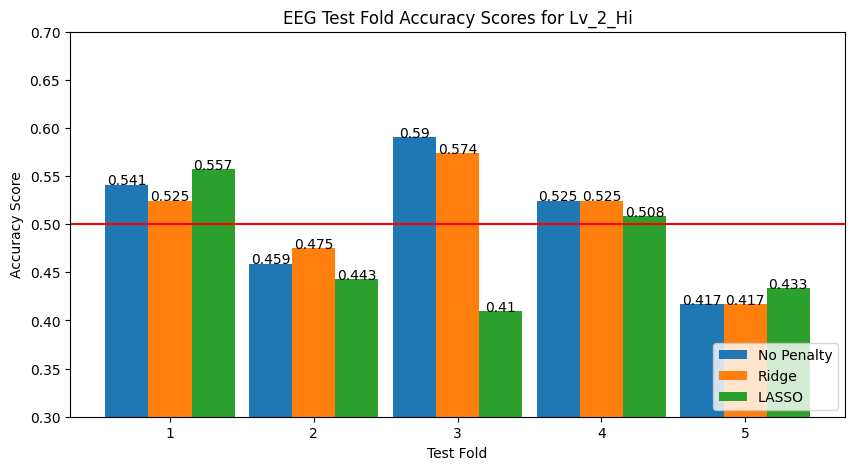

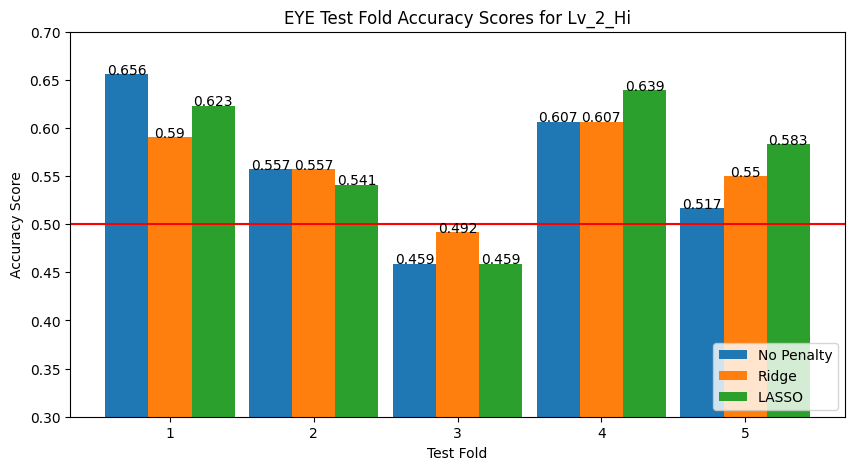

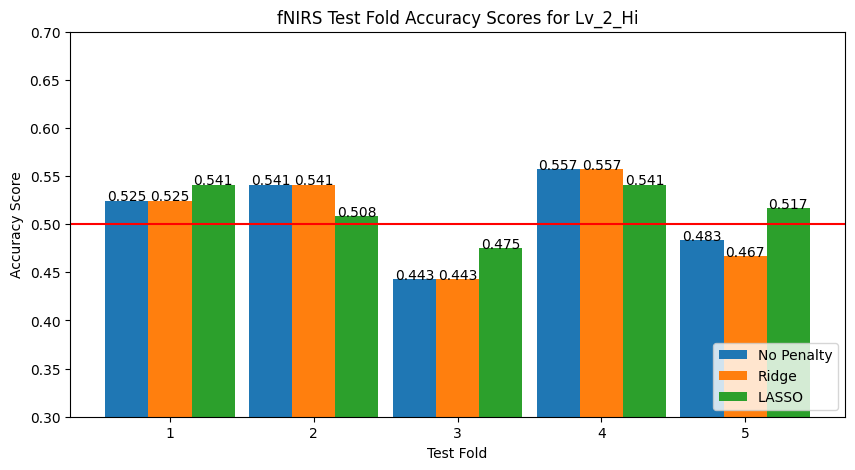

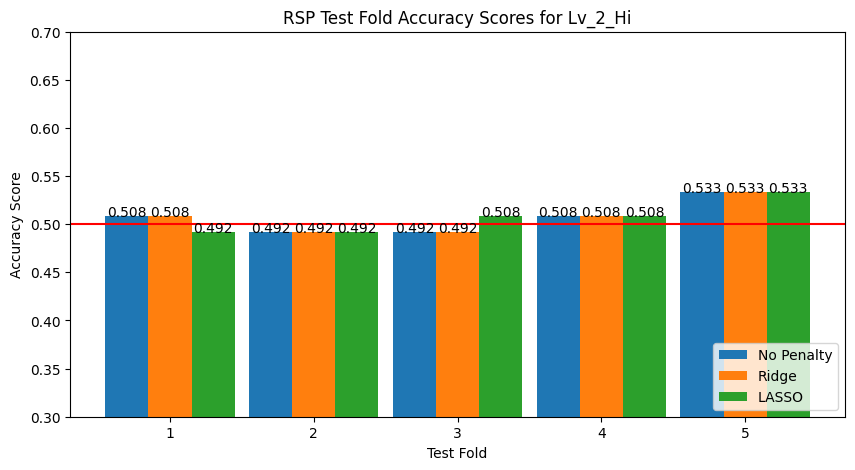

In [13]:
graph_folds(all_sensor_test_scores, "Lv_2_Hi")